In [1]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

/home/formanj/miniconda3/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/formanj/miniconda3/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/formanj/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataloc = [r"GSM6118768_Galdos_Seq_Run1_filtered_feature_bc_matrix.h5", 
           r"GSM6118769_Galdos_Seq_Run2_filtered_feature_bc_matrix.h5", 
           r"GSM6118770_Galdos_Seq_Run3_filtered_feature_bc_matrix.h5"]

Functions

In [3]:
def dayseperation(adata):
    # dealing with HTOs
    HTOs = [HTOs for HTOs in adata.var_names if 'DAY' in HTOs]
    print(HTOs)
    htodata = adata[:, HTOs]
    sc.pp.normalize_total(htodata, target_sum=1e4) #normalize every cell to 10,000 UMI
    for hto in HTOs:
        plt.plot(htodata[0:20, hto].X.todense())
    plt.show()
    
    adata.obs['time'] = np.zeros(adata.shape[0])
    for i in range(adata.shape[0]):
        groupindex = np.argmax(htodata[i,:].X.toarray())
        adata.obs['time'][i] = htodata.var_names[groupindex]
    
    n_hto = adata.obs['time'].value_counts().to_dict()
    
    print(n_hto)
    
    plt.bar(range(len(n_hto)), list(n_hto.values()), tick_label=list(n_hto.keys()))
    plt.show()
    
    # removes HTOs so that they dont effect future processes, especially after normalization
    non_HTOs = [name for name in adata.var_names if name not in HTOs]
    adata = adata[:, non_HTOs].copy()
    return adata


In [4]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

def pp(filepath):
    adata = sc.read_10x_h5(filepath, gex_only=False)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 10)
    adata = dayseperation(adata)
    adata.write_h5ad('H5AD_'+filepath.split('_')[3]+'.h5ad')

    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train(batch_size=127)
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_h5ad('H5AD_'+filepath.split('_')[3]+'.h5ad')
    adata.obs['Sample'] = filepath.split('_')[3] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata



Doublet Removal

/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


['LMNA_DAY1', 'LMNA_DAY2', 'LMNA_DAY3', 'LMNA_DAY4', 'LMNA_DAY5', 'LMNA_DAY6', 'WTC_DAY1', 'WTC_DAY2', 'WTC_DAY3', 'WTC_DAY4', 'WTC_DAY5', 'WTC_DAY6']


/home/formanj/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/formanj/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


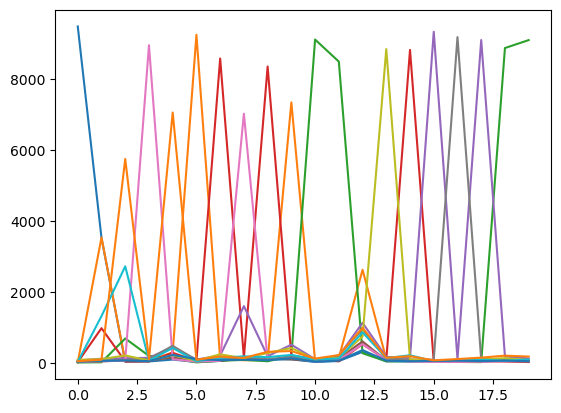

/tmp/ipykernel_67309/723750758.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['time'][i] = htodata.var_names[groupindex]
/tmp/ipykernel_67309/723750758.py:14: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  adata.obs['time'][i] = htodata.var_names[groupindex]
/tmp/ipykernel_67309/723750758.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LMNA_DAY1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs['time'][i] = htodata.var_names[groupindex]


{'WTC_DAY2': 1780, 'WTC_DAY4': 1667, 'WTC_DAY3': 1655, 'LMNA_DAY1': 1644, 'LMNA_DAY2': 1542, 'LMNA_DAY6': 1541, 'LMNA_DAY5': 1488, 'WTC_DAY1': 1423, 'LMNA_DAY4': 1373, 'WTC_DAY6': 1317, 'WTC_DAY5': 1290, 'LMNA_DAY3': 1288}


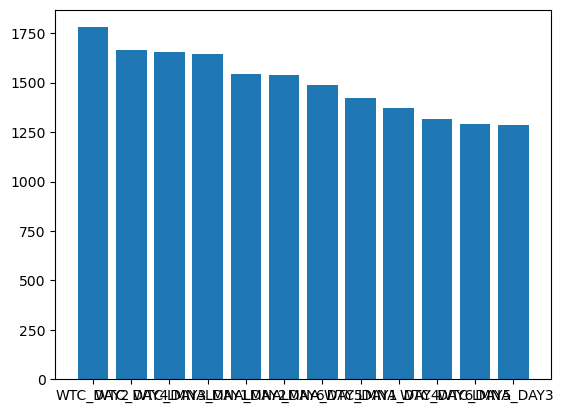

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 400/400: 100%|██████████| 400/400 [05:26<00:00,  1.23it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.27e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:26<00:00,  1.23it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.27e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 144/400:  36%|███▌      | 144/400 [01:48<03:13,  1.32it/s, v_num=1, train_loss_step=0.229, train_loss_epoch=0.356]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.355. Signaling Trainer to stop.


AttributeError: module 'scanpy' has no attribute 'read_10x_h5ad'

In [5]:
out = []
for file in dataloc:
    out.append(pp(file))

In [ ]:
for i in range(len(out)):
    out[i].var_names_make_unique()

adata = ad.concat(out)
sc.pp.filter_genes(adata, min_cells = 10)
adata.X = csr_matrix(adata.X)
adata.write_h5ad('combined.h5ad')

/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Day seperation

In [ ]:
adata = dayseperation(adata)

[]


/home/formanj/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/formanj/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/formanj/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


ValueError: attempt to get argmax of an empty sequence

<1053x11511 sparse matrix of type '<class 'numpy.float32'>'
	with 803317 stored elements in Compressed Sparse Row format>

Integration

In [ ]:
#%% Normilization
# Unequal waiting of genes
sc.pp.filter_genes(adata, min_cells = 100)

adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=5000)

adata.raw = adata
#adata = adata[:, adata.var.highly_variable]
#sc.pp.regress_out(adata[i_d], ['total_counts', 'pct_counts_mt']) # regresses out effect
#sc.pp.scale(adata[i_d], max_value=10) # treats all genes the same
    

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["batch"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
model = scvi.model.SCVI(adata)
model.train() #may take a while without GPU

Latent Representation

In [ ]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color = ['leiden', 'batch'], frameon = False)